In [48]:
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import os
import sys
import json
from matplotlib.collections import LineCollection
import lmfit

# from clustering_scripts import *

In [49]:
DATADIR = "../data/"
FIGDIR = "../img/"

In [50]:
FROM_I = 5.0
TO_I = 15.0
I_SAMPLES = 21
ANGLE_SAMPLES = 50
RING_SAMPLES_X = 10
RING_SAMPLES_Y = 10

I = np.linspace(FROM_I, TO_I, I_SAMPLES)
angles = np.linspace(0.0, 0.5 * np.pi, ANGLE_SAMPLES)
angles_x = np.linspace(0.0, 2.0 * np.pi, RING_SAMPLES_X)
angles_y = np.linspace(0.0, 2.0 * np.pi, RING_SAMPLES_X)

my_shape = (I_SAMPLES, ANGLE_SAMPLES, RING_SAMPLES_X, RING_SAMPLES_Y)

In [131]:
with h5py.File(os.path.join(DATADIR, "amplitude_4_b1_worst_zeta_avg.h5"), "r") as f:
    x0 = f["reference/initial/x_norm"][:].reshape(my_shape)
    px0 = f["reference/initial/px_norm"][:].reshape(my_shape)
    y0 = f["reference/initial/y_norm"][:].reshape(my_shape)
    py0 = f["reference/initial/py_norm"][:].reshape(my_shape)
    zeta0 = f["reference/initial/zeta_norm"][:].reshape(my_shape)
    pzeta0 = f["reference/initial/pzeta_norm"][:].reshape(my_shape)

    amplitude0 = np.sqrt(x0 ** 2 + px0 ** 2 + y0 ** 2 + py0 ** 2 + zeta0 ** 2 + pzeta0 ** 2)

    theta_x_0 = np.arctan2(x0, px0)
    theta_y_0 = np.arctan2(y0, py0)

    times = list(sorted([int(s) for s in f["track/x_norm/"].keys()]))

    x = np.array([f["track/x_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    px = np.array([f["track/px_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    y = np.array([f["track/y_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    py = np.array([f["track/py_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    zeta = np.array([f["track/zeta_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    pzeta = np.array([f["track/pzeta_norm/{}/".format(t)][:].reshape(my_shape) for t in times])

    amplitude = np.sqrt(x ** 2 + px ** 2 + y ** 2 + py ** 2 + zeta ** 2 + pzeta ** 2)

    theta_x = np.arctan2(x, px)
    theta_y = np.arctan2(y, py)

In [112]:
times[-1]

46297

In [113]:
with open("/home/HPC/camontan/lhc_paper_indicators/amplitude_tracking/config/particles.json", "r") as f:
    initial_conditions = json.load(f)

with open("/home/HPC/camontan/lhc_paper_indicators/amplitude_tracking/config/appendix.json", "r") as f:
    appendix = json.load(f)

amplitude_x0 = np.asarray(appendix["amplitude_x"]).reshape(my_shape)
amplitude_y0 = np.asarray(appendix["amplitude_y"]).reshape(my_shape)

In [114]:
np.unique(appendix["amplitude"])

array([ 5. ,  5. ,  5. ,  5. ,  5.5,  5.5,  5.5,  6. ,  6. ,  6. ,  6. ,
        6.5,  6.5,  6.5,  6.5,  7. ,  7. ,  7. ,  7. ,  7.5,  7.5,  7.5,
        7.5,  7.5,  8. ,  8. ,  8. ,  8.5,  8.5,  8.5,  9. ,  9. ,  9. ,
        9.5,  9.5,  9.5, 10. , 10. , 10. , 10. , 10.5, 10.5, 10.5, 10.5,
       11. , 11. , 11. , 11.5, 11.5, 11.5, 12. , 12. , 12. , 12. , 12.5,
       12.5, 12.5, 13. , 13. , 13. , 13. , 13.5, 13.5, 13.5, 13.5, 14. ,
       14. , 14. , 14. , 14.5, 14.5, 14.5, 14.5, 15. , 15. , 15. , 15. ,
       15. ])

In [132]:
theta_x.shape

(271, 21, 50, 10, 10)

In [115]:
amplitude_mean = np.nanmean(amplitude, axis=(-1,-2))
amplitude0_mean = np.nanmean(amplitude0, axis=(-1,-2))
amplitude_std = np.nanstd(amplitude, axis=(-1,-2))
alive = np.count_nonzero(~np.isnan(amplitude), axis=(-1,-2))


/tmp/ipykernel_36219/1128466083.py:1: RuntimeWarning: Mean of empty slice
  amplitude_mean = np.nanmean(amplitude, axis=(-1,-2))
/home/HPC/camontan/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [134]:
theta_x_mean = np.nanmean(theta_x, axis=(-3, -1))
theta_y_mean = np.nanmean(theta_y, axis=(-3, -2))
theta_x_std = np.nanstd(theta_x, axis=(-3, -1))
theta_y_std = np.nanstd(theta_y, axis=(-3, -2))

(array([ 9.,  7., 13., 14.,  9., 10.,  9., 15.,  8., 11.,  9.,  7., 12.,
         7.,  4.,  5.,  6., 14.,  9., 13., 12.,  7.,  9., 10.,  5., 11.,
        12., 11., 11.,  4.,  8.,  8.,  8., 15., 11., 17.,  9., 11., 17.,
         9., 12., 11., 12.,  8., 16., 14.,  4., 12.,  4., 11.]),
 array([-3.1214324 , -2.99723377, -2.87303514, -2.74883651, -2.62463788,
        -2.50043925, -2.37624062, -2.25204199, -2.12784336, -2.00364473,
        -1.8794461 , -1.75524746, -1.63104883, -1.5068502 , -1.38265157,
        -1.25845294, -1.13425431, -1.01005568, -0.88585705, -0.76165842,
        -0.63745979, -0.51326116, -0.38906253, -0.2648639 , -0.14066526,
        -0.01646663,  0.107732  ,  0.23193063,  0.35612926,  0.48032789,
         0.60452652,  0.72872515,  0.85292378,  0.97712241,  1.10132104,
         1.22551967,  1.34971831,  1.47391694,  1.59811557,  1.7223142 ,
         1.84651283,  1.97071146,  2.09491009,  2.21910872,  2.34330735,
         2.46750598,  2.59170461,  2.71590324,  2.84010188,

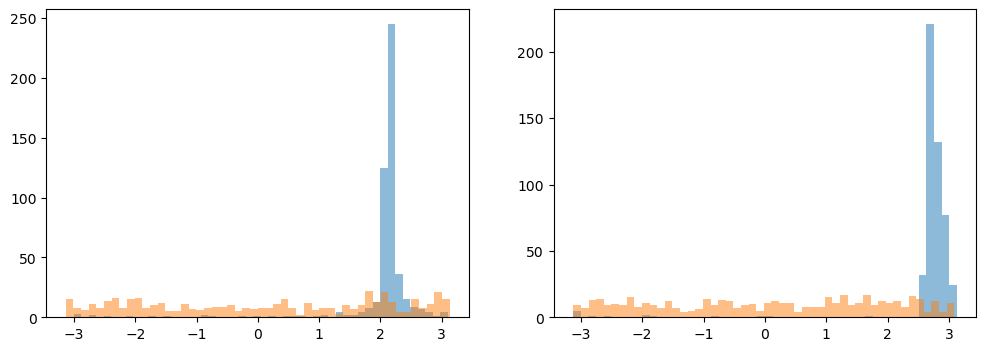

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(theta_x[0, 0, :, -1, :].flatten(), bins=50, alpha=0.5)
axs[0].hist(theta_x[-1, 0, :, -1, :].flatten(), bins=50, alpha=0.5)

axs[1].hist(theta_y[0, 0, :, :, -1].flatten(), bins=50, alpha=0.5)
axs[1].hist(theta_y[-1, 0, :, :, -1].flatten(), bins=50, alpha=0.5)

In [97]:
amplitude_std.shape

(255, 21, 50)

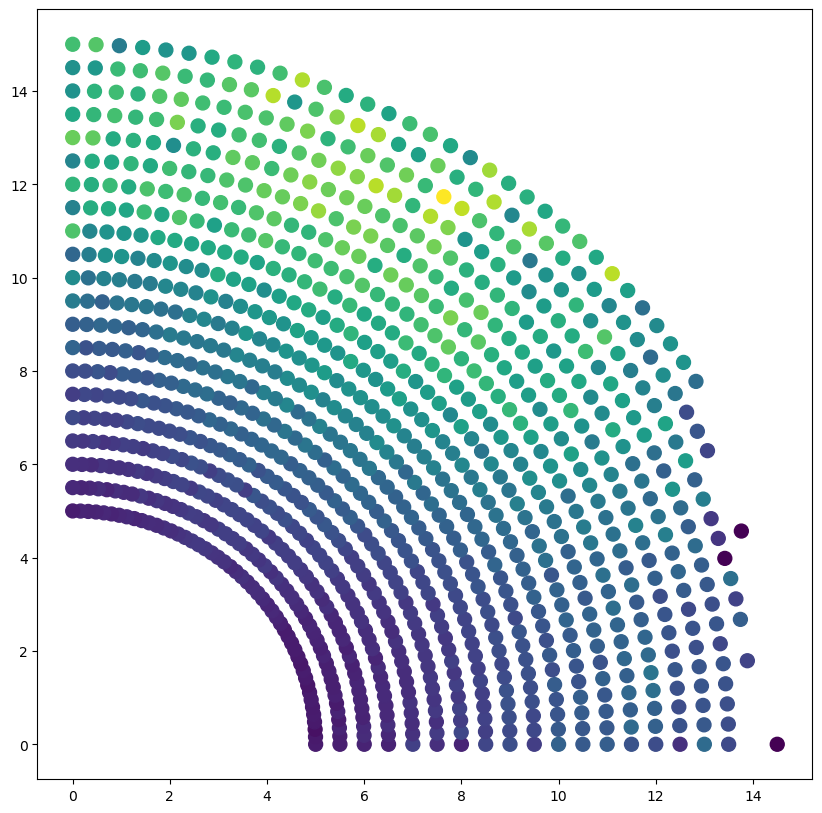

In [98]:
a_std_max = np.nanmax(amplitude_std[-1])
a_std_min = np.nanmin(amplitude_std[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=a_std_min, vmax=a_std_max)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=amplitude_std[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

In [10]:
with h5py.File(os.path.join(DATADIR, "rem_b1_worst_zeta_max.h5"), "r") as f:
    times = list(sorted([int(s) for s in f["reverse/x_norm"].keys()]))
    rem = np.array(
        [
            np.power(f[f"reverse/x_norm/{t}"][:] - f["reference/initial/x_norm"][:], 2) +
            np.power(f[f"reverse/y_norm/{t}"][:] - f["reference/initial/y_norm"][:], 2) +
            np.power(f[f"reverse/px_norm/{t}"][:] - f["reference/initial/px_norm"][:], 2) +
            np.power(f[f"reverse/py_norm/{t}"][:] - f["reference/initial/py_norm"][:], 2) +
            np.power(f[f"reverse/zeta_norm/{t}"][:] - f["reference/initial/zeta_norm"][:], 2) +
            np.power(f[f"reverse/pzeta_norm/{t}"][:] - f["reference/initial/pzeta_norm"][:], 2)
            for t in times
        ])
    
with h5py.File(os.path.join(DATADIR, "log_displacement_b1_worst_zeta_max.h5"), "r") as f:
    amplitude = np.sqrt(
        f["reference/initial/x_norm"][:]**2 + f["reference/initial/y_norm"][:]**2
    )

with h5py.File(os.path.join(DATADIR, "stability_b1_worst_zeta_max.h5"), "r") as f:
    stability = f["stability"][:]

DYN_EXTENT = (0.0, 14.5, 0.0, 15.5)

In [11]:
final_rem = np.zeros_like(rem[-1]) * np.nan

for i in range(len(final_rem)):
    # for each particle, find the last rem value that is not nan
    # and set the final_rem value to that
    try:
        final_rem[i] = rem[np.where(~np.isnan(rem[:,i]))[0][-1], i]
    except IndexError:
        final_rem[i] = np.nan

clean_final_rem = final_rem.copy()[stability <= 1e5]
clean_stability = stability.copy()[stability <= 1e5]

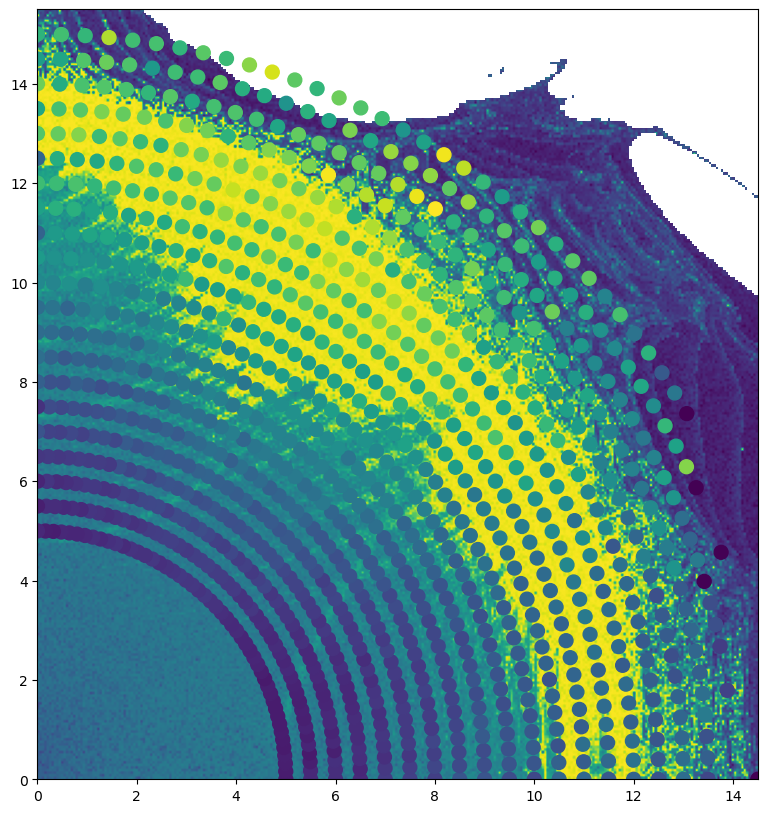

In [57]:
a_std_max = np.nanmax(amplitude_std[-1])
a_std_min = np.nanmin(amplitude_std[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=a_std_min, vmax=a_std_max)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(np.log10(final_rem).reshape(300, 300), origin="lower", extent=DYN_EXTENT, cmap="viridis")


for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=amplitude_std[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

In [13]:
def power_fit(params, x, data=None):
    a = params["a"].value
    b = params["b"].value
    c = params["c"].value

    model = a + b*np.log10(x)
    model[model > c] = c

    if data is None:
        return 10**model
    
    return model - np.log10(data)


def exp_fit(params, x, data=None):
    a = params["a"].value
    b = params["b"].value
    c = params["c"].value

    model = a + (b * x)
    model[model > c] = c

    if data is None:
        return 10**model
    
    return model - np.log10(data)

In [14]:
out_power = []
out_exp = []

for i in tqdm(range(len(rem[-1]))):
    if np.all(np.isnan(rem[:,i])):
        out_power.append([np.nan, np.nan, np.nan])
        out_exp.append([np.nan, np.nan, np.nan])
        continue
    
    y = rem[20:,i]
    mask = (~np.isnan(y)) & (np.isfinite(y))
    x = np.asarray(times[20:])[mask]
    y = y[mask]
    y /= rem[0, i]

    if np.all(np.isnan(y)) or len(y) < 2:
        out_power.append([np.nan, np.nan, np.nan])
        out_exp.append([np.nan, np.nan, np.nan])
        continue

    lmfit_params = lmfit.Parameters()
    lmfit_params.add("a", value=1)
    lmfit_params.add("b", value=1)
    lmfit_params.add("c", value=23.38413861926543, vary=False)

    lmfit_out_power = lmfit.minimize(power_fit, lmfit_params, args=(x, y))

    lmfit_params = lmfit.Parameters()
    lmfit_params.add("a", value=1)
    lmfit_params.add("b", value=0.001)
    lmfit_params.add("c", value=23.38413861926543, vary=False)

    lmfit_out_exp = lmfit.minimize(exp_fit, lmfit_params, args=(x, y))

    out_power.append([lmfit_out_power.params["a"].value, lmfit_out_power.params["b"].value, lmfit_out_power.redchi])
    out_exp.append([lmfit_out_exp.params["a"].value, lmfit_out_exp.params["b"].value, lmfit_out_exp.redchi])


  0%|          | 0/90000 [00:00<?, ?it/s]

In [15]:
chroma = np.array([
    np.nan if np.isnan(out_power[i][2]) else
    0.0 if out_power[i][2] > out_exp[i][2] else 
    1.0 for i in range(len(out_power))
])

b_power = np.array([out_power[i][1] for i in range(len(out_power))])
b_exp = np.array([out_exp[i][1] for i in range(len(out_exp))])

(array([0.22414024, 0.        , 0.04482805, 0.        , 0.        ,
        0.04482805, 0.22414024, 0.40345243, 0.53793657, 0.71724876,
        0.76207681, 0.62759267, 0.67242072, 1.16552924, 1.25518534,
        0.62759267, 0.85173291, 0.89656095, 1.16552924, 1.16552924,
        0.53793657, 0.62759267, 0.98621705, 0.71724876, 0.89656095,
        0.89656095, 0.89656095, 0.67242072, 1.12070119, 0.71724876,
        0.89656095, 1.16552924, 0.76207681, 0.62759267, 0.62759267,
        0.40345243, 0.85173291, 0.941389  , 0.67242072, 0.40345243,
        0.35862438, 0.40345243, 0.35862438, 0.35862438, 0.53793657,
        0.44828048, 0.53793657, 0.35862438, 0.53793657, 0.49310852,
        0.49310852, 0.58276462, 0.40345243, 0.22414024, 0.35862438,
        0.76207681, 0.62759267, 0.85173291, 0.40345243, 0.62759267,
        0.49310852, 0.62759267, 0.40345243, 0.44828048, 0.53793657,
        0.35862438, 0.71724876, 0.44828048, 0.53793657, 0.35862438,
        0.35862438, 0.49310852, 0.31379633, 0.35

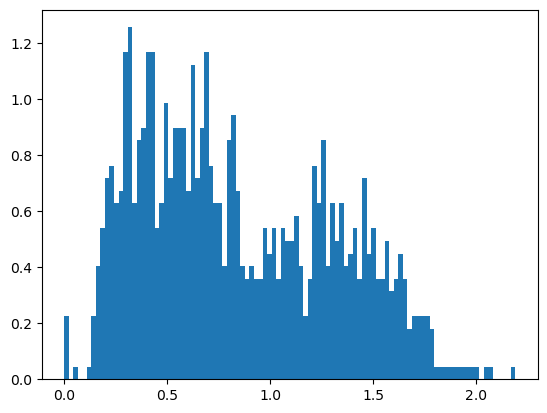

In [85]:
plt.hist(amplitude_std[-1].flatten(), bins=100, density=True)

/tmp/ipykernel_36219/3368098594.py:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(b_exp).copy()


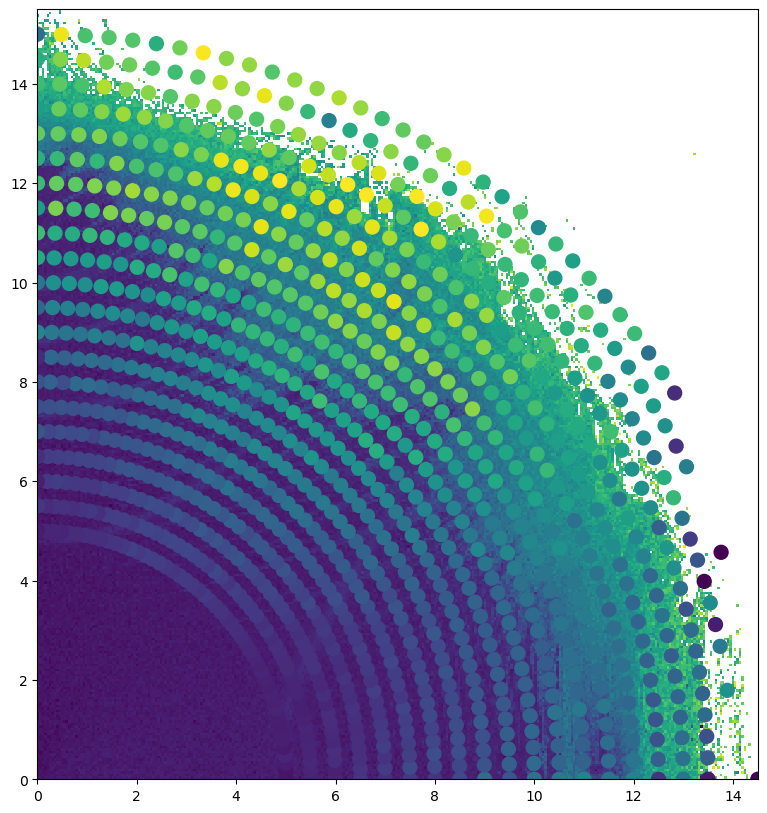

In [116]:
fig, ax = plt.subplots(figsize=(10, 10))

tmp = np.log10(b_exp).copy()
# tmp[chroma != 0] = np.nan
ax.imshow(tmp.reshape(300, 300), origin="lower", interpolation="nearest", extent=DYN_EXTENT, cmap="viridis")

amp_max = np.nanmax(amplitude_std[-1])
amp_min = np.nanmin(amplitude_std[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=amp_min, vmax=amp_max*0.9)

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=amplitude_std[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

In [117]:
x_rem = np.linspace(DYN_EXTENT[0], DYN_EXTENT[1], 300)
y_rem = np.linspace(DYN_EXTENT[2], DYN_EXTENT[3], 300)
X_rem, Y_rem = np.meshgrid(x_rem, y_rem)

from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator(
    (x_rem, y_rem),
     np.log10(b_exp).copy().reshape((300, 300)).T,
    bounds_error=False,
)

/tmp/ipykernel_36219/969534569.py:9: RuntimeWarning: invalid value encountered in log10
  np.log10(b_exp).copy().reshape((300, 300)).T,


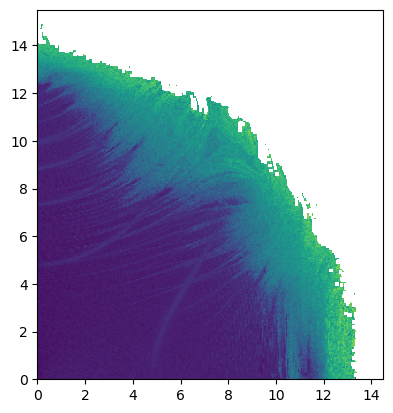

In [118]:
plt.imshow(interp((X_rem, Y_rem)), extent=DYN_EXTENT, origin="lower", cmap="viridis")

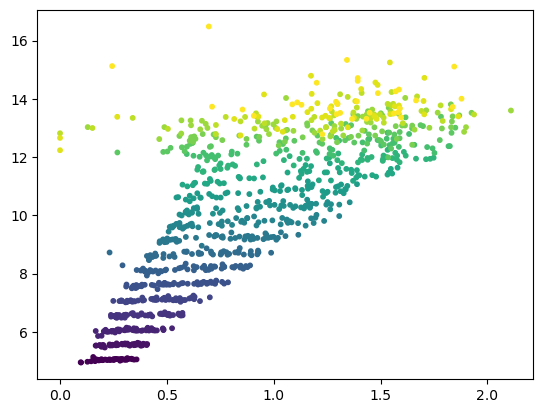

In [119]:
plt.scatter(amplitude_std[-1], amplitude_mean[-1], s=10, c=amplitude0[:,:,0,0], cmap="viridis")

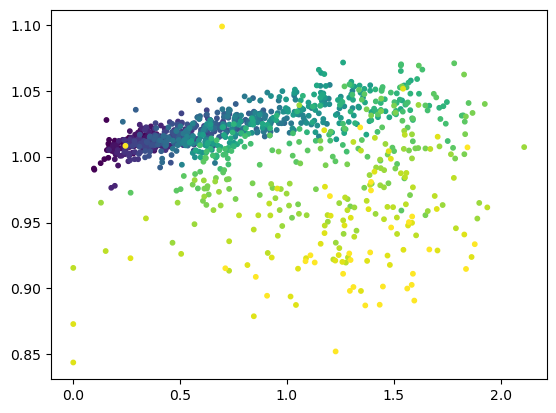

In [120]:
plt.scatter(amplitude_std[-1], amplitude_mean[-1]/amplitude0[:,:,0,0], s=10, c=amplitude0[:,:,0,0], cmap="viridis")

In [130]:
%matplotlib widget
# One can bound figure attributes to other widget values.
from ipywidgets import AppLayout, FloatSlider

plt.ioff()

slider = FloatSlider(
    orientation='horizontal',
    description='Factor:',
    value=len(times)-1,
    min=0,
    max=len(times)-1
)

slider.layout.margin = '0px 30% 0px 30%'
slider.layout.width = '40%'

fig = plt.figure()
# fig.canvas.header_visible = False
# fig.canvas.layout.min_height = '400px'
# plt.title('Plotting: y=sin({} * x)'.format(slider.value))

# x = np.linspace(0, 20, 500)

sc = plt.scatter(amplitude_std[-1], amplitude_mean[-1]/amplitude0[:,:,0,0], s=10, c=amplitude0[:,:,0,0], cmap="viridis")

def update_scatter(index):
    print(index)
    sc.set_offsets((np.c_[amplitude_std[index], amplitude_mean[index]/amplitude0[:,:,0,0]]))
    fig.canvas.draw()
    fig.canvas.flush_events()

slider.observe(update_scatter, names='value')

AppLayout(
    center=fig.canvas,
    footer=slider,
    pane_heights=[0, 6, 1]
)

AppLayout(children=(FloatSlider(value=258.0, description='Factor:', layout=Layout(grid_area='footer', margin='…

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 0.8333333134651184, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 0.8333333134651184, 'type': 'set_device_pixel_ratio'}


{'name': 'value', 'old': 258.0, 'new': 254.0, 'owner': FloatSlider(value=254.0, description='Factor:', layout=Layout(grid_area='footer', margin='0px 30% 0px 30%', width='40%'), max=258.0), 'type': 'change'}


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

{'name': 'value', 'old': 254.0, 'new': 164.9, 'owner': FloatSlider(value=164.9, description='Factor:', layout=Layout(grid_area='footer', margin='0px 30% 0px 30%', width='40%'), max=258.0), 'type': 'change'}


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

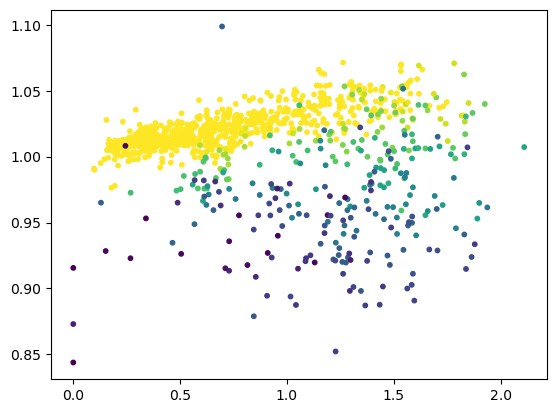

In [121]:
plt.scatter(amplitude_std[-1], amplitude_mean[-1]/amplitude0[:,:,0,0], s=10, c=alive[-1], cmap="viridis")

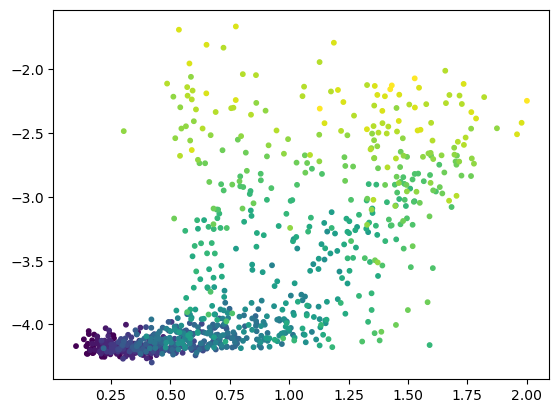

In [ ]:
plt.scatter(amplitude_std[-1], interp((amplitude_x0[:,:,0,0], amplitude_y0[:,:,0,0])), s=10, c=amplitude0[:,:,0,0], cmap="viridis")

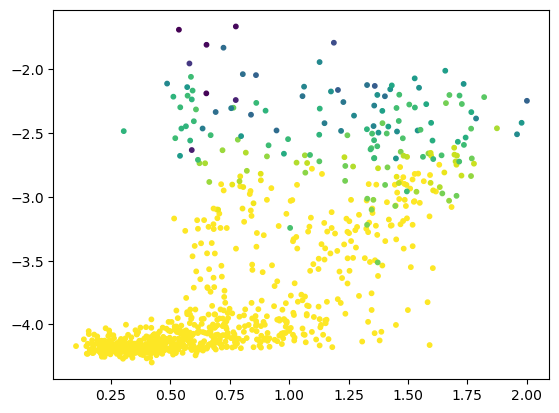

In [100]:
plt.scatter(amplitude_std[-1], interp((amplitude_x0[:,:,0,0], amplitude_y0[:,:,0,0])), s=10, c=alive[-1], cmap="viridis")

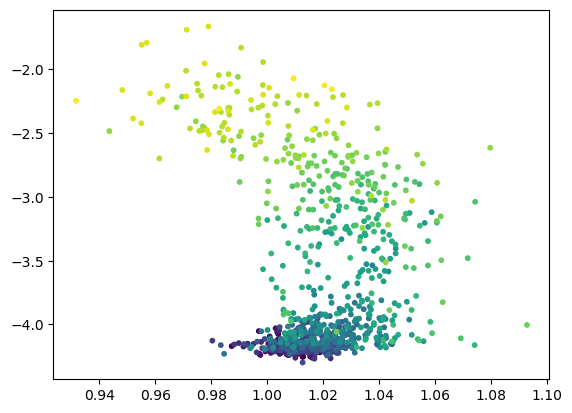

In [90]:
plt.scatter(amplitude_mean[-1]/amplitude0[:,:,0,0], interp((amplitude_x0[:,:,0,0], amplitude_y0[:,:,0,0])), s=10, c=amplitude0[:,:,0,0], cmap="viridis")

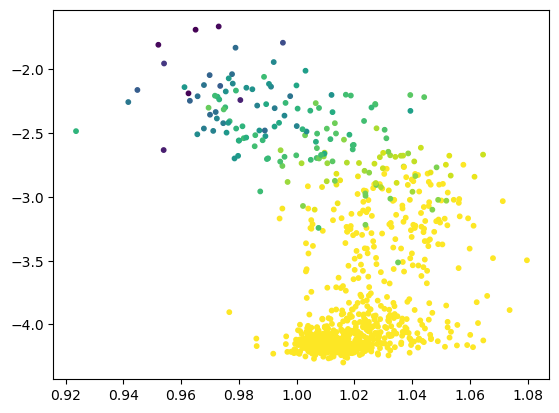

In [101]:
plt.scatter(amplitude_mean[-1]/amplitude0[:,:,0,0], interp((amplitude_x0[:,:,0,0], amplitude_y0[:,:,0,0])), s=10, c=alive[-1], cmap="viridis")

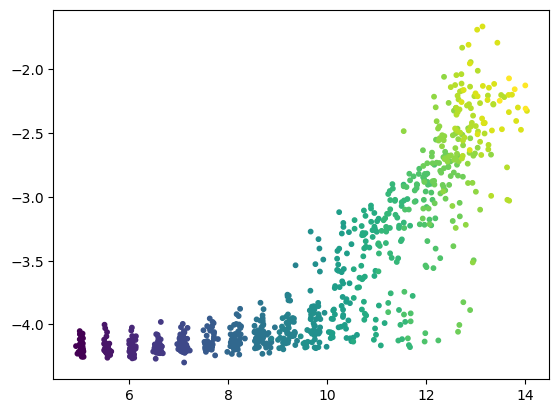

In [102]:
plt.scatter(amplitude_mean[-1], interp((amplitude_x0[:,:,0,0], amplitude_y0[:,:,0,0])), s=10, c=amplitude0[:,:,0,0], cmap="viridis")

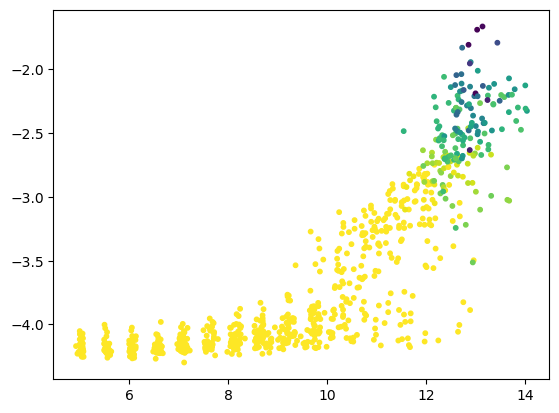

In [103]:
plt.scatter(amplitude_mean[-1], interp((amplitude_x0[:,:,0,0], amplitude_y0[:,:,0,0])), s=10, c=alive[-1], cmap="viridis")

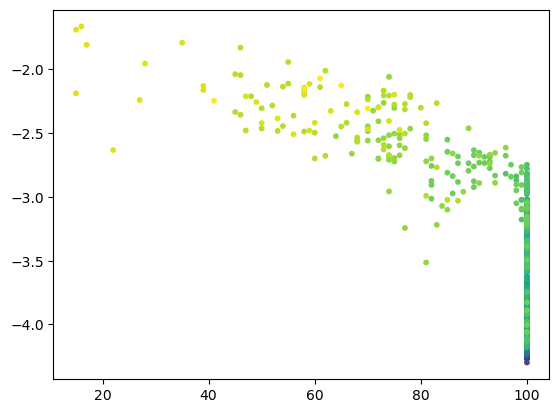

In [91]:
plt.scatter(alive[-1], interp((amplitude_x0[:,:,0,0], amplitude_y0[:,:,0,0])), s=10, c=amplitude0[:,:,0,0], cmap="viridis")

AppLayout(children=(FloatSlider(value=1.0, description='Factor:', layout=Layout(grid_area='footer', margin='0p…

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 0.8333333134651184, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 0.8333333134651184, 'type': 'set_device_pixel_ratio'}


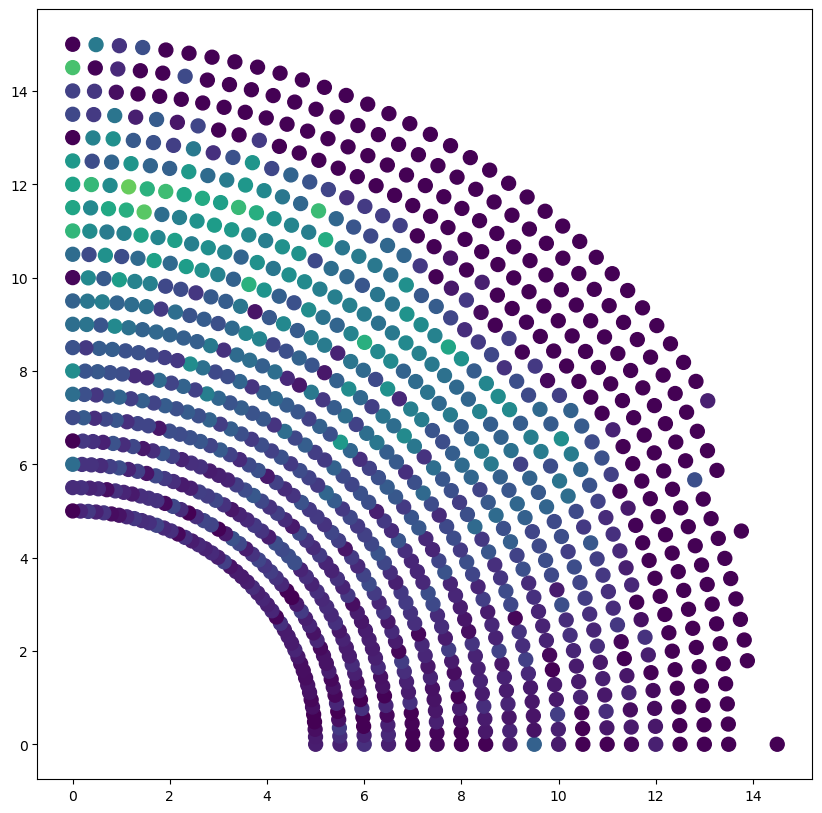

In [44]:
a_mean_max = np.nanmax(amplitude_mean[-1])
a_mean_min = np.nanmin(amplitude_mean[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=1, vmax=1.1)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=amplitude_mean[-1,i]/np.sqrt((amplitude_x0[i,:,0,0]**2 + amplitude_y0[i,:,0,0]**2)),
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

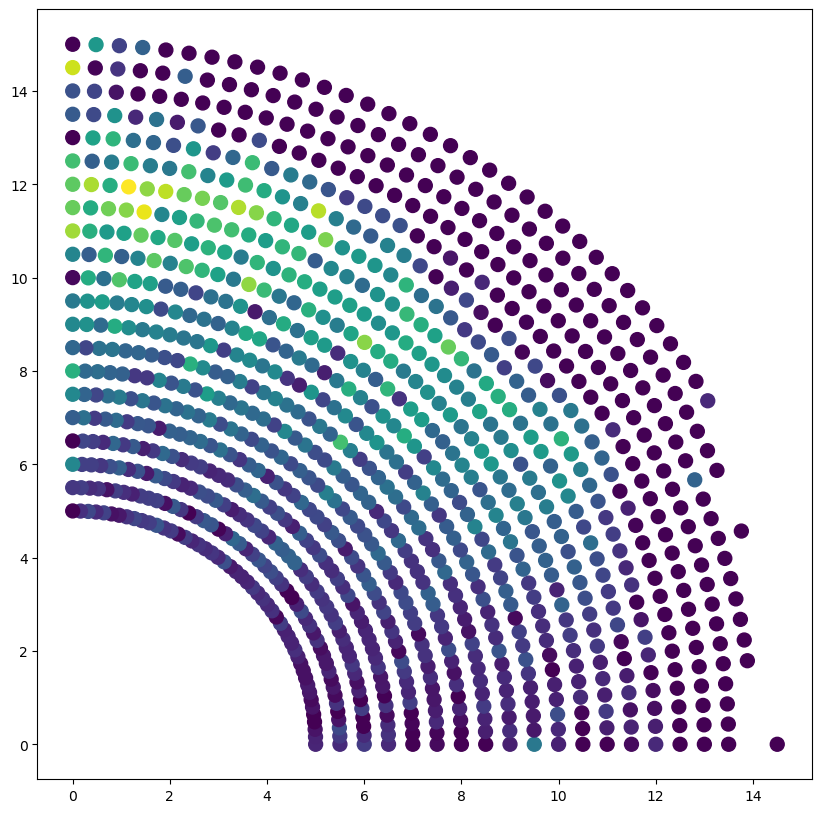

In [46]:
my_amp = amplitude_mean / amplitude0_mean
a_mean_max = np.nanmax(my_amp[-1])
a_mean_min = np.nanmin(my_amp[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=1, vmax=a_mean_max)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=my_amp[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

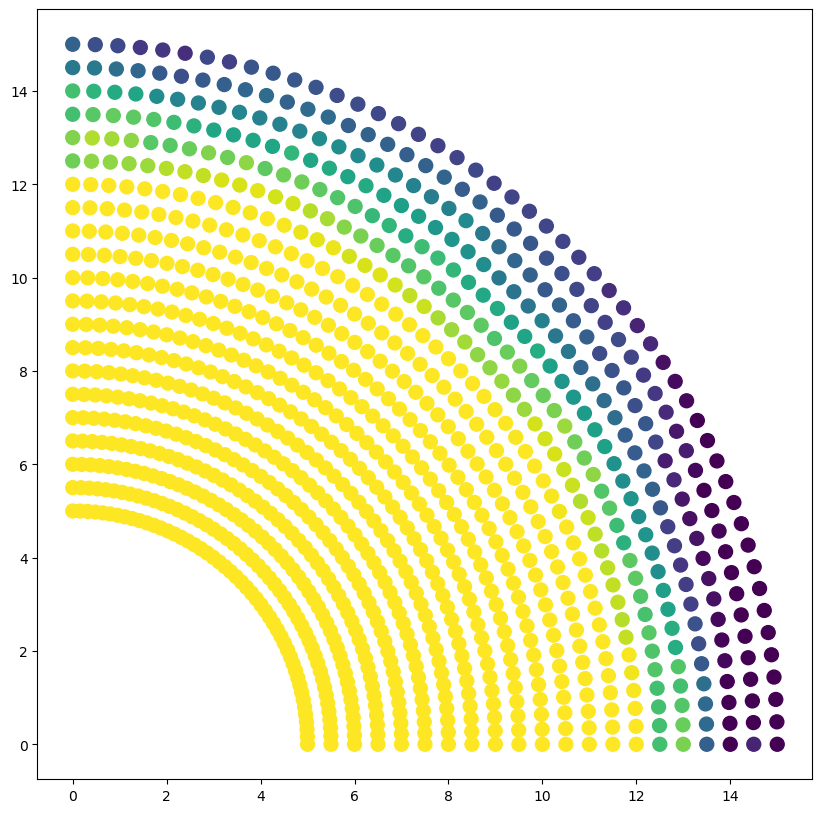

In [47]:
my_val = alive
a_mean_max = np.nanmax(my_val[-1])
a_mean_min = np.nanmin(my_val[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=a_mean_min, vmax=a_mean_max)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=my_val[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )